# Deep learning predicts prevalent and incident Parkinson's disease (PD)

## The goal of this project is to diagnose Parkinson's disease subjects apart from age-gender matched healthy controls under a binary classification framework. 

# 1. Environment 

### The PyTorch 1.7.1 in HiperGator is what I use. I imagine most other PyTorch versions will work. 


#### We will download some other packages later but the base environment should do fine for the most part.

I personally use the following settings on ood hipergaor

- 2 CPU's
- 20 mem GB
- time = 12 hours (need at most 4 hours for a single experiment), 12 is flexible for a work day.
- 1 A100 GPU (hpg-ai, gpu:a100:1)

# 2. Data Acquisition and Organization

(Estimated-Time) 20 minutes to set things up

### Obviously create your own folder for the project in your own blue home-folder.

You should create the following general sub-folders:

1. data
2. models
3. code

###  Once you do this then copy the zip file for the project either by dragging or the linux command below ( cp ) 

In [ ]:
!cp '/blue/ruogu.fang/charlietran/PD_Reproduction/data/PD_raw_data.zip' -d 'your_blue_project_folder' 

#### You can unzip the zip file for this project using the command below

In [21]:
import os

# Change the path of the data zip file
# The unzip command follows source -d destination 
# You can keep it inside of the data folder
# We will use -q here (quiet) to suprses the outpus


!unzip -q '/blue/ruogu.fang/charlietran/PD_Reproduction/data/PD_raw_data.zip' -d '/blue/ruogu.fang/charlietran/PD_Reproduction/data/'

### The folder Raw_Data should be here now which contain the raw fundus images. The folders that matter are

- PD  
- HC (the age and gender matched controls to the PD subjects)

- PD_prevalent 
- PD_prevalent_hc (the subset of HC controls matched to the prevalen PD subjects)

- PD_incident (the subset of PD subjects that are incident)
- PD_incident_hc (the subset of HC controls matched to the incident PD subjects)




### We can do a brief count of the number of subjects and images for each folder 

In [38]:
import numpy as np 
def subject_counter(folder): 
    # Every image has a unique eid belonging to the subjec.
    # There are repeat ID's because a subject may have a left and right eye. 
    # We just count up the number of unique IDS
    
    
    array_of_eids = [] 
    
    for img in os.listdir(folder):
        array_of_eids.append(img[0:7])
        
    return len(np.unique(array_of_eids))
    

def image_counter(folder):
    # We just print the number of images for each folder. 
    # This function is ridiculously simple anyway
    
    return len(os.listdir(folder))


# Change these directories here
PD_folder = '/blue/ruogu.fang/charlietran/PD_Reproduction/data/Raw_Data/PD/'
HC_folder = '/blue/ruogu.fang/charlietran/PD_Reproduction/data/Raw_Data/HC/'
PD_subject_count, PD_image_count = subject_counter(PD_folder), subject_counter(HC_folder)
print('PD Subject Count:', PD_subject_count)
print('PD Image Count:', PD_image_count)
print('----------------------------------------------------------------------------------')




#################

# Repeat the commands above changing the directories from prevalent to incident

###################3



# Change these directories here
PD_folder = '/blue/ruogu.fang/charlietran/PD_Reproduction/data/Raw_Data/PD_prevalent/'
HC_folder = '/blue/ruogu.fang/charlietran/PD_Reproduction/data/Raw_Data/PD_prevalent_hc/'
PD_subject_count, PD_image_count = subject_counter(PD_folder), subject_counter(HC_folder)
print('PD Subject Count:', PD_subject_count)
print('PD Image Count:', PD_image_count)
print('----------------------------------------------------------------------------------')




# Change these directories here
PD_folder = '/blue/ruogu.fang/charlietran/PD_Reproduction/data/Raw_Data/PD_incident/'
HC_folder = '/blue/ruogu.fang/charlietran/PD_Reproduction/data/Raw_Data/PD_incident_hc/'
PD_subject_count, PD_image_count = subject_counter(PD_folder), subject_counter(HC_folder)
print('PD Subject Count:', PD_subject_count)
print('PD Image Count:', PD_image_count)
print('----------------------------------------------------------------------------------')

PD Subject Count: 84
PD Image Count: 91
----------------------------------------------------------------------------------
PD Subject Count: 53
PD Image Count: 55
----------------------------------------------------------------------------------
PD Subject Count: 31
PD Image Count: 38
----------------------------------------------------------------------------------


### You can always plot a sample image from the data folder

(-0.5, 2047.5, 1535.5, -0.5)

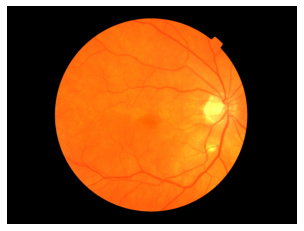

In [53]:
import matplotlib.pyplot as plt 
from PIL import Image

sample_folder = '/blue/ruogu.fang/charlietran/PD_Reproduction/data/Raw_Data/PD/'
# we want to choose the a random image from the folder so,
index = 0 # choose the 0th index from the folder
image = plt.imread(sample_folder + os.listdir(sample_folder)[index])
plt.imshow(image)
plt.axis('off')

# 3. Data resizing, splitting, and new-data folders.

(Estimated-Time) ~ 30 minutes to save all the folders

## Let's create new folders for the kfold data splitting, for 

1. Overall 
2. Prevalent 
3. Incident

We will eventually use 5-repeated 5-fold fold validation. We will need 25 x 3 folders total.

R will stand for repetition - that is, a repetition of 5-fold validation

The data will be resized to 512 x 512 with cv2 during the process.

In [118]:


os.makedirs('/blue/ruogu.fang/charlietran/PD_Reproduction/data/Overall_KFold_Data/', exist_ok = True)
os.makedirs('/blue/ruogu.fang/charlietran/PD_Reproduction/data/Overall_KFold_Data/R1/', exist_ok = True)
os.makedirs('/blue/ruogu.fang/charlietran/PD_Reproduction/data/Overall_KFold_Data/R2/', exist_ok = True)
os.makedirs('/blue/ruogu.fang/charlietran/PD_Reproduction/data/Overall_KFold_Data/R3/', exist_ok = True)
os.makedirs('/blue/ruogu.fang/charlietran/PD_Reproduction/data/Overall_KFold_Data/R4/', exist_ok = True)
os.makedirs('/blue/ruogu.fang/charlietran/PD_Reproduction/data/Overall_KFold_Data/R5/', exist_ok = True)

os.makedirs('/blue/ruogu.fang/charlietran/PD_Reproduction/data/Prevalent_KFold_Data/', exist_ok = True)
os.makedirs('/blue/ruogu.fang/charlietran/PD_Reproduction/data/Prevalent_KFold_Data/R1/', exist_ok = True)
os.makedirs('/blue/ruogu.fang/charlietran/PD_Reproduction/data/Prevalent_KFold_Data/R2/', exist_ok = True)
os.makedirs('/blue/ruogu.fang/charlietran/PD_Reproduction/data/Prevalent_KFold_Data/R3/', exist_ok = True)
os.makedirs('/blue/ruogu.fang/charlietran/PD_Reproduction/data/Prevalent_KFold_Data/R4/', exist_ok = True)
os.makedirs('/blue/ruogu.fang/charlietran/PD_Reproduction/data/Prevalent_KFold_Data/R5/', exist_ok = True)

os.makedirs('/blue/ruogu.fang/charlietran/PD_Reproduction/data/Incident_KFold_Data/', exist_ok = True)
os.makedirs('/blue/ruogu.fang/charlietran/PD_Reproduction/data/Incident_KFold_Data/R1/', exist_ok = True)
os.makedirs('/blue/ruogu.fang/charlietran/PD_Reproduction/data/Incident_KFold_Data/R2/', exist_ok = True)
os.makedirs('/blue/ruogu.fang/charlietran/PD_Reproduction/data/Incident_KFold_Data/R3/', exist_ok = True)
os.makedirs('/blue/ruogu.fang/charlietran/PD_Reproduction/data/Incident_KFold_Data/R4/', exist_ok = True)
os.makedirs('/blue/ruogu.fang/charlietran/PD_Reproduction/data/Incident_KFold_Data/R5/', exist_ok = True)



### This code will be repeated three times, depending on the PD / Prevalent / Incident. 

The trick here about the data-splitting is that we will use five-fold cross validaion on the unique subject IDS themselves to organize the data.

We will be using the arguments PD_tag and HC_tag to be the name of the sub-folders from the base-folder (e.g.)

Overall:
- PD_tag = 'PD'
- HC_tag = 'HC'

Prevalent: 
- PD_tag = 'PD_prevalent'
- HC_tag = 'PD_prevalent_hc'

Incident:
- PD_tag = 'PD_incident'
- HC_tag = 'PD_incident_hc'

In [113]:
import os 
from PIL import Image
import numpy as np
from sklearn.model_selection import StratifiedKFold
from scipy import stats
import matplotlib.pyplot as plt
import imageio
import cv2
import warnings
warnings.filterwarnings("ignore")


def data_splitter(input_path,
                  PD_tag, 
                  HC_tag, 
                  output_folder,
                  seed_number):
    path = input_path
    files = os.listdir(path)
    hc_path = os.path.join(path, PD_tag)
    pd_path = os.path.join(path, HC_tag)

    N = 5 
    ids = [] 
    for img in os.listdir(pd_path):
        ids.append(img[0:7] + '_PD')
    for img in os.listdir(hc_path):
        ids.append(img[0:7] + '_CN')
    unique_ids = np.unique(ids) #

    labels = [] 

    for id in unique_ids:
        if id[-2:] == 'CN':
            labels.append(0)
        elif id[-2:] == 'PD':
            labels.append(1)

    labels = np.array(labels)
    count = 0
    dim = (512,512)
    kf_outer = StratifiedKFold(n_splits= 5, random_state = seed_number, shuffle = True)  
    for train_index, test_index in kf_outer.split(unique_ids, labels):
        train_ids, test_ids = unique_ids[train_index], unique_ids[test_index]
        train_lbls, test_lbls = labels[train_index], labels[test_index]  

        cn_train_list = [] 
        ad_train_list = []

        count += 1
        #print(pd_path)
        save_path = os.path.join(output_folder, str(count))
        #save_path = os.path.join(path, str(count)) 


        os.makedirs(os.path.join(save_path, 'train'), exist_ok = True) # create train file

        os.makedirs(os.path.join(save_path, 'test'), exist_ok = True) # create test file
        save_pd_train_path = os.path.join(save_path, 'train','PD')
        os.makedirs(save_pd_train_path, exist_ok = True)    # create tran/PD/
        save_hc_train_path = os.path.join(save_path, 'train', 'HC')
        os.makedirs(save_hc_train_path, exist_ok = True) # create /train/HC/

        for eid in train_ids:

            #split images to /train/PD/
            if eid[-2:] == 'PD':
                for img in os.listdir(pd_path):
                    if str(eid[0:7]) in img:
                        image =  plt.imread(os.path.join(pd_path,img))           
                        image =cv2.resize(image, dim)
                        #print(os.path.join(save_pd_train_path,img))
                        imageio.imwrite(os.path.join(save_pd_train_path,img), image)

            # split images to /train/HC/
            if eid[-2:] == 'CN':
                for img in os.listdir(hc_path):
                    if str(eid[0:7]) in img:
                        image =  plt.imread(os.path.join(hc_path,img))
                        image =cv2.resize(image, dim)
                        imageio.imwrite(os.path.join(save_hc_train_path,img), image)

        save_pd_test_path = os.path.join(save_path, 'test','PD')
        os.makedirs(save_pd_test_path, exist_ok = True) # create /test/PD/
        save_hc_test_path = os.path.join(save_path, 'test', 'HC')
        os.makedirs(save_hc_test_path, exist_ok = True) # create /test/HC/

        for eid in test_ids:
            #split images to /test/PD/
            if eid[-2:] == 'PD':
                for img in os.listdir(pd_path):
                    if str(eid[0:7]) in img:
                        image =  plt.imread(os.path.join(pd_path,img))     
                        image =cv2.resize(image, dim)
                        #print(os.path.join(save_pd_test_path,img))
                        imageio.imwrite(os.path.join(save_pd_test_path,img), image)
            #split images to /test/PD/
            if eid[-2:] == 'CN':
                for img in os.listdir(hc_path):
                    if str(eid[0:7]) in img:
                        image =  plt.imread(os.path.join(hc_path,img))
                        image = cv2.resize(image, dim)
                        imageio.imwrite(os.path.join(save_hc_test_path,img), image)
                        
        #shutil.copy(input_path 


# Overall Data Split

In [114]:
import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger().setLevel(logging.ERROR)

#self reminder I used this link: https://stackoverflow.com/questions/52165705/how-to-ignore-root-warnings 
# to figure out how to remove the warnings

# Change paths 5 times and the seed numbers in [5, 25, 50, 75, 100] 
# Remember that we are using the convention R1 R2 R3 R4 R5 for each repeated kfold
# Or make a better way by for looping or some other smart way. 

data_splitter(input_path = '/blue/ruogu.fang/charlietran/PD_Reproduction/data/Raw_Data/', 
              PD_tag = 'PD', 
              HC_tag = 'HC',
              output_folder = '/blue/ruogu.fang/charlietran/PD_Reproduction/data/Overall_KFold_Data/R1/',
              seed_number = 5) 

data_splitter(input_path = '/blue/ruogu.fang/charlietran/PD_Reproduction/data/Raw_Data/', 
              PD_tag = 'PD', 
              HC_tag = 'HC',              
              output_folder = '/blue/ruogu.fang/charlietran/PD_Reproduction/data/Overall_KFold_Data/R2/',
              seed_number = 25) 

data_splitter(input_path = '/blue/ruogu.fang/charlietran/PD_Reproduction/data/Raw_Data/', 
              PD_tag = 'PD', 
              HC_tag = 'HC',
              output_folder = '/blue/ruogu.fang/charlietran/PD_Reproduction/data/Overall_KFold_Data/R3/',
              seed_number = 50) 

data_splitter(input_path = '/blue/ruogu.fang/charlietran/PD_Reproduction/data/Raw_Data/', 
              PD_tag = 'PD', 
              HC_tag = 'HC',
              output_folder = '/blue/ruogu.fang/charlietran/PD_Reproduction/data/Overall_KFold_Data/R4/',
              seed_number = 75) 

data_splitter(input_path = '/blue/ruogu.fang/charlietran/PD_Reproduction/data/Raw_Data/', 
              PD_tag = 'PD', 
              HC_tag = 'HC',
              output_folder = '/blue/ruogu.fang/charlietran/PD_Reproduction/data/Overall_KFold_Data/R5/',
              seed_number = 100) 

## Prevalent Data Split

We will be changing the tags to be PD_prevalent and PD_prevalent_hc along with the output prevalent folder.

In [115]:
import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger().setLevel(logging.ERROR)

#self reminder I used this link: https://stackoverflow.com/questions/52165705/how-to-ignore-root-warnings 
# to figure out how to remove the warnings

# Change paths 5 times and the seed numbers in [5, 25, 50, 75, 100] 
# Remember that we are using the convention R1 R2 R3 R4 R5 for each repeated kfold
# Or make a better way by for looping or some other smart way. 





data_splitter(input_path = '/blue/ruogu.fang/charlietran/PD_Reproduction/data/Raw_Data/', 
              PD_tag = 'PD_prevalent', 
              HC_tag = 'PD_prevalent_hc',
              output_folder = '/blue/ruogu.fang/charlietran/PD_Reproduction/data/Prevalent_KFold_Data/R1/',
              seed_number = 5) 

data_splitter(input_path = '/blue/ruogu.fang/charlietran/PD_Reproduction/data/Raw_Data/', 
              PD_tag = 'PD_prevalent', 
              HC_tag = 'PD_prevalent_hc',           
              output_folder = '/blue/ruogu.fang/charlietran/PD_Reproduction/data/Prevalent_KFold_Data/R2/',
              seed_number = 25) 

data_splitter(input_path = '/blue/ruogu.fang/charlietran/PD_Reproduction/data/Raw_Data/', 
              PD_tag = 'PD_prevalent', 
              HC_tag = 'PD_prevalent_hc',
              output_folder = '/blue/ruogu.fang/charlietran/PD_Reproduction/data/Prevalent_KFold_Data/R3/',
              seed_number = 50) 

data_splitter(input_path = '/blue/ruogu.fang/charlietran/PD_Reproduction/data/Raw_Data/', 
              PD_tag = 'PD_prevalent', 
              HC_tag = 'PD_prevalent_hc',
              output_folder = '/blue/ruogu.fang/charlietran/PD_Reproduction/data/Prevalent_KFold_Data/R4/',
              seed_number = 75) 

data_splitter(input_path = '/blue/ruogu.fang/charlietran/PD_Reproduction/data/Raw_Data/', 
              PD_tag = 'PD_prevalent', 
              HC_tag = 'PD_prevalent_hc',
              output_folder = '/blue/ruogu.fang/charlietran/PD_Reproduction/data/Prevalent_KFold_Data/R5/',
              seed_number = 100) 

## Incident Data Split

We will be changing the tags to be PD_incident and PD_incident_hc along with the output incident folder.

In [119]:
import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger().setLevel(logging.ERROR)

#self reminder I used this link: https://stackoverflow.com/questions/52165705/how-to-ignore-root-warnings 
# to figure out how to remove the warnings

# Change paths 5 times and the seed numbers in [5, 25, 50, 75, 100] 
# Remember that we are using the convention R1 R2 R3 R4 R5 for each repeated kfold
# Or make a better way by for looping or some other smart way. 

data_splitter(input_path = '/blue/ruogu.fang/charlietran/PD_Reproduction/data/Raw_Data/', 
              PD_tag = 'PD_incident', 
              HC_tag = 'PD_incident_hc',
              output_folder = '/blue/ruogu.fang/charlietran/PD_Reproduction/data/Incident_KFold_Data/R1/',
              seed_number = 5) 

data_splitter(input_path = '/blue/ruogu.fang/charlietran/PD_Reproduction/data/Raw_Data/', 
              PD_tag = 'PD_incident', 
              HC_tag = 'PD_incident_hc',           
              output_folder = '/blue/ruogu.fang/charlietran/PD_Reproduction/data/Incident_KFold_Data/R2/',
              seed_number = 25) 

data_splitter(input_path = '/blue/ruogu.fang/charlietran/PD_Reproduction/data/Raw_Data/', 
              PD_tag = 'PD_incident', 
              HC_tag = 'PD_incident_hc',
              output_folder = '/blue/ruogu.fang/charlietran/PD_Reproduction/data/Incident_KFold_Data/R3/',
              seed_number = 50) 

data_splitter(input_path = '/blue/ruogu.fang/charlietran/PD_Reproduction/data/Raw_Data/', 
              PD_tag = 'PD_incident', 
              HC_tag = 'PD_incident_hc',
              output_folder = '/blue/ruogu.fang/charlietran/PD_Reproduction/data/Incident_KFold_Data/R4/',
              seed_number = 75) 

data_splitter(input_path = '/blue/ruogu.fang/charlietran/PD_Reproduction/data/Raw_Data/', 
              PD_tag = 'PD_incident', 
              HC_tag = 'PD_incident_hc',
              output_folder = '/blue/ruogu.fang/charlietran/PD_Reproduction/data/Incident_KFold_Data/R5/',
              seed_number = 100) 

# 4. K-Fold Validation. Model training and Evaluation

### If you did not already know, use the command !nvidia-smi to check the gpu usage on hipergator in the case that someone else is using it. We will only be needing one gpu (A100)

Look at os.environ["CUDA_VISIBLE_DEVICES"] = "0" if you want to change gpu index

In [ ]:
!nvidia-smi

In [2]:
import os

## ** As you continue onward, you should create new cells for each model ** 

Your choices are alexnet, vgg, resnet, googlenet, inceptionv3. Go down to the bottom of the main section of each code and change

1. the DL model name [alexnet, vgg, resnet, googlenet, inceptionv3] or the ML model name [svm_linear, svm_rbf, logistic_regression, elastic_net]
2. the base directory of the project
3. the experiment tag: [overall, prevalent, incident]

## 4.1.1 Deep Learning Training (Overall, AlexNet)

In [9]:
import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger().setLevel(logging.ERROR)

In [19]:
import torchvision.models as models
import torch
from torch.utils.data import DataLoader, random_split, ConcatDataset
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
import os
import torchvision.models as models
import numpy as np
from torchvision import transforms
#import tensorboard_logger as tb_logger
#from torchsampler import ImbalancedDatasetSampler
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


def main():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p =0.4),
        transforms.RandomVerticalFlip(p = 0.4),
        transforms.RandomRotation(50),
        transforms.ToTensor(),
        transforms.Resize(256),
        normalize,
    ])
    val_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(256),
        normalize,
    ])
 
    train = datasets.ImageFolder(train_path, transform= train_transform)
    val  = datasets.ImageFolder(test_path, transform= train_transform)

    train_dataloader = DataLoader(train, batch_size=train_bsz, shuffle = True)
    val_dataloader = DataLoader(val, batch_size = val_bsz, shuffle = True)    
    
    
    if model_name == 'alexnet':
        model = models.alexnet(pretrained = True)
        model.classifier[6] = nn.Linear(in_features = 4096, out_features = 2, bias = True)
    if model_name == 'vgg':
        model = models.vgg16(pretrained=True)
        model.classifier[6] = nn.Linear(in_features=4096, out_features=2, bias=True)
    if model_name == 'resnet':
        model = models.resnet50(pretrained = True) # Pre-train on imagenet
        model.fc = nn.Linear(in_features = 2048, out_features = 2) # Convert to binary classification
    if model_name == 'googlenet':
        model = models.googlenet(pretrained = True)
        model.fc = nn.Linear(in_features = 1024, out_features = 2) 
    if model_name == 'inceptionv3':
        model = models.inception_v3(pretrained = True)
        model.fc = nn.Linear(in_features = 2048, out_features = 2)  
        model.aux_logits = False
        
 
        
    model = model.cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)

    def model_train(model, dataloader):
        model.train()
        tr_loss = []
        for i, data in enumerate(dataloader, 0):
            optimizer.zero_grad()
            image, labels = data
            image = image.float().cuda()
            labels = labels.long().cuda()
            output = model(image)
       
            #class_pred = torch.argmax(output, dim = 1)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            tr_loss.append(loss.item())


       # print('Training Loss:', np.average(tr_loss, axis=0))
        avg_tr_loss = np.average(tr_loss, axis=0)
        return avg_tr_loss

    def model_eval(model, dataloader):
        model.eval()
        val_loss = []
        with torch.no_grad():
            for i, data in enumerate(dataloader, 0):
                optimizer.zero_grad()
                image, labels = data
                image = image.float().cuda()
                labels = labels.long().cuda()
                output = model(image)
                loss = criterion(output, labels)
                val_loss.append(loss.item())
      #  print('Validation Loss:', np.average(val_loss, axis=0))
        avg_val_loss = np.average(val_loss, axis=0)
        return avg_val_loss

    # initialize val loss counter to be high for early stopping method
    val_loss_counter = [100000000] # Initialize to a very large number

    for epoch in range(max_num_epochs):
        training_loss = model_train(model, train_dataloader)
        validation_loss = model_eval(model, val_dataloader)
       # print(epoch,'Training Loss:', training_loss, 'Validation Loss', validation_loss)
        if validation_loss <= np.amin(val_loss_counter):
            torch.save({'model_state_dict': model.state_dict(),
            }, output_model_dir )
            #torch.save({'model_state_dict': model.state_dict(), output_model_dir})            
            print('Model has been saved to', output_model_dir)
 
        val_loss_counter.append(validation_loss)

if __name__ == '__main__':
    
    ### You need to change the base data_folder based on the eperiment (Overall, Prevalent, Incident)
    # Your options are [alexnet, vgg, resnet, googlenet, inceptionv3]
    model_name = 'alexnet' 
    base_folder = '/blue/ruogu.fang/charlietran/PD_Reproduction/' 
    experiment_tag = 'overall' 

    
    if experiment_tag == 'overall': 
        data_extension = 'Overall_KFold_Data'
    if experiment_tag == 'prevalent':
        data_extension == 'Prevalent_KFold_Data'
    if experiment_tag == 'incident':
        data_extension = 'Incident_KFold_Data'

    for j in range(1,6):
        for k in range(1,6):
            train_path = os.path.join(base_folder, 'data',  data_extension, 'R' + str(j),  str(k) , 'train')
            test_path =  os.path.join(base_folder, 'data', data_extension, 'R' + str(j), str(k) , 'test')
            output_model_dir = os.path.join(base_folder, 'models', experiment_tag, model_name,  model_name + 'weights' + '_' + str(j) + '_' + str(k) + '.pth')
            os.makedirs(os.path.join(base_folder, 'models', experiment_tag, model_name), exist_ok = True)
            learning_rate = 1e-4
            train_bsz = 64
            val_bsz = 64
            max_num_epochs = 2
            main()
    print('Confirm Model Output Name:', model_name)

Model has been saved to /blue/ruogu.fang/charlietran/PD_Reproduction/models/overall/alexnet/alexnetweights_1_1.pth
Model has been saved to /blue/ruogu.fang/charlietran/PD_Reproduction/models/overall/alexnet/alexnetweights_1_1.pth
Model has been saved to /blue/ruogu.fang/charlietran/PD_Reproduction/models/overall/alexnet/alexnetweights_1_2.pth
Model has been saved to /blue/ruogu.fang/charlietran/PD_Reproduction/models/overall/alexnet/alexnetweights_1_2.pth
Model has been saved to /blue/ruogu.fang/charlietran/PD_Reproduction/models/overall/alexnet/alexnetweights_1_3.pth
Model has been saved to /blue/ruogu.fang/charlietran/PD_Reproduction/models/overall/alexnet/alexnetweights_1_3.pth
Model has been saved to /blue/ruogu.fang/charlietran/PD_Reproduction/models/overall/alexnet/alexnetweights_1_4.pth
Model has been saved to /blue/ruogu.fang/charlietran/PD_Reproduction/models/overall/alexnet/alexnetweights_1_4.pth
Model has been saved to /blue/ruogu.fang/charlietran/PD_Reproduction/models/over

# 4.1.1 Testing (Overall, AlexNet)

In [21]:
import torch
from torch.utils.data import DataLoader, ConcatDataset, random_split
import torchvision.datasets as datasets
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import os
import torch.backends.cudnn as cudnn
import torchvision.models as models
import numpy as np
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from sklearn.metrics import classification_report
from torchvision import transforms
from sklearn.metrics import roc_auc_score

def main():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(256),
        normalize,
    ])

    test  = datasets.ImageFolder(test_path, transform= test_transform)
    test_dataloader = DataLoader(test, batch_size=bsz, shuffle = False)
    if model_name == 'alexnet':
        model = models.alexnet(pretrained = True)
        model.classifier[6] = nn.Linear(in_features = 4096, out_features = 2, bias = True)
    if model_name == 'vgg':
        model = models.vgg16(pretrained=True)
        model.classifier[6] = nn.Linear(in_features=4096, out_features=2, bias=True)
    if model_name == 'resnet':
        model = models.resnet50(pretrained = True) # Pre-train on imagenet
        model.fc = nn.Linear(in_features = 2048, out_features = 2) # Convert to binary classification
    if model_name == 'googlenet':
        model = models.googlenet(pretrained = True)
        model.fc = nn.Linear(in_features = 1024, out_features = 2) 
    if model_name == 'inceptionv3':
        model = models.inception_v3(pretrained = True)
        model.fc = nn.Linear(in_features = 2048, out_features = 2)  
        model.aux_logits = False
        
    checkpoint = torch.load(output_model_dir)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    model = model.cuda()

    def computeAUC(dataGT, dataPRED):
        datanpGT = dataGT.cpu().numpy()
        datanpPRED = dataPRED.cpu().numpy()
        return roc_auc_score(datanpGT, datanpPRED)

    def class_report(dataGT, predCLASS):
        datanpGT = dataGT.cpu().numpy()
        datanppredCLASS = predCLASS.cpu().numpy()

        return classification_report(datanpGT, datanppredCLASS, digits = 3, output_dict = True)

    def model_test(model, dataloader):
        model.eval()
        outGT = torch.FloatTensor().cuda()
        outPRED = torch.FloatTensor().cuda()
        outCLASS = torch.FloatTensor().cuda()
        with torch.no_grad():
            for i, data in enumerate(dataloader, 0):
                image, labels = data
                image = image.float().cuda()
                labels = labels.float().cuda()
                output = model(image) # The output current is (N, C) where it is actually (N, 2)
                m = nn.Softmax(dim = 1)
                output_probabilities = m(output)
                class_pred = torch.argmax(output_probabilities, dim = 1)
                outPRED = torch.cat((outPRED, output_probabilities[:, -1]), 0)
                outGT = torch.cat((outGT, labels), 0)
                outCLASS = torch.cat((outCLASS, class_pred), 0)
        auc_test = computeAUC(outGT, outPRED)
        report = class_report(outGT, outCLASS)
       # print(report)
        return auc_test, report, outPRED, outCLASS, outGT
    auc_test,report, outPRED, outCLASS, outGT = model_test(model, test_dataloader)
   # print('TEST AUC:', auc_test)
    auc_scores.append(auc_test)
    accuracy_scores.append(report['accuracy'])
    ppv_scores.append(report['1.0']['precision'])
    npv_scores.append(report['0.0']['precision'])
    sensitivity_scores.append(report['1.0']['recall'])
    specificity_scores.append(report['0.0']['recall'])
    f1_scores.append(report['1.0']['f1-score'])
    
    parkinson_probability.append(outPRED.cpu().detach().numpy())
    class_predictions.append(outCLASS.cpu().detach().numpy())
    ground_truth.append(outGT.cpu().detach().numpy())
   # print(report['accuracy'], ',')



if __name__ == '__main__':
    auc_scores = [] 
    accuracy_scores = []
    ppv_scores = [] 
    npv_scores = [] 
    sensitivity_scores = [] 
    specificity_scores = [] 
    f1_scores = [] 
    parkinson_probability = [] 
    class_predictions = []
    ground_truth = []
      
    model_name = 'alexnet' 
    base_folder = '/blue/ruogu.fang/charlietran/PD_Reproduction/' 
    experiment_tag = 'overall' 

    
    if experiment_tag == 'overall': 
        data_extension = 'Overall_KFold_Data'
    if experiment_tag == 'prevalent':
        data_extension == 'Prevalent_KFold_Data'
    if experiment_tag == 'incident':
        data_extension = 'Incident_KFold_Data'      
        
        
    for j in range(1,6):
        for k in range(1,6):
            train_path = os.path.join(base_folder, 'data',  data_extension, 'R' + str(j),  str(k) , 'train')
            test_path =  os.path.join(base_folder, 'data', data_extension, 'R' + str(j), str(k) , 'test')
            output_model_dir = os.path.join(base_folder, 'models', experiment_tag, model_name,  model_name + 'weights' + '_' + str(j) + '_' + str(k) + '.pth')
            bsz = 64
            max_num_epochs = 100    
            main()
        
    print('---------------------------------------------------------------')
    print('AVERAGE SCORE REPORT')
    print('---------------------------------------------------------------')
    print('AVERAGE AUC', '{:.2f}'.format(np.average(auc_scores)),'({:.2f})'.format(np.std(auc_scores)))
    print('AVERAGE Accuracy', '{:.2f}'.format(np.average(accuracy_scores)),'({:.2f})'.format(np.std(accuracy_scores)))
    print('AVERAGE PPV', '{:.2f}'.format(np.average(ppv_scores)),'({:.2f})'.format(np.std(ppv_scores)))
    print('AVERAGE NPV', '{:.2f}'.format(np.average(npv_scores)), '({:.2f})'.format(np.std(npv_scores)))
    print('AVERAGE Sensitivity', '{:.2f}'.format(np.average(sensitivity_scores)), '({:.2f})'.format(np.std(sensitivity_scores)))
    print('AVERAGE Specificity', '{:.2f}'.format(np.average(specificity_scores)), '({:.2f})'.format(np.std(specificity_scores)))
    print('AVERAGE F1 scores', '{:.2f}'.format(np.average(f1_scores)),'({:.2f})'.format(np.std(f1_scores)))
    print('---------------------------------------------------------------')



    output_base_dir_name = os.path.join(base_folder, 'results', experiment_tag, model_name)
    os.makedirs(output_base_dir_name, exist_ok = True)

    np.save(output_base_dir_name, model_name + '_' + 'auc_scores.npy', auc_scores)
    np.save(output_base_dir_name, model_name + '_' + 'accuracy_scores.npy', accuracy_scores)
    np.save(output_base_dir_name, model_name + '_' + 'ppv_scores.npy', ppv_scores)
    np.save(output_base_dir_name, model_name + '_' + 'npv_score.npy', npv_scores)
    np.save(output_base_dir_name, model_name + '_' + 'sensitivity_scores.npy', sensitivity_scores)
    np.save(output_base_dir_name, model_name + '_' + 'specificity_scores.npy', specificity_scores)
    np.save(output_base_dir_name, model_name + '_' + 'f1_scores.npy', f1_scores)
    np.save(output_base_dir_name, model_name + '_' + 'pd_probability.npy', parkinson_probability)
    np.save(output_base_dir_name, model_name + '_' + 'class_predictions.npy', class_predictions)
    np.save(output_base_dir_name, model_name + '_' + 'ground_truth.npy', ground_truth)


    # print statements
    print('SAVING:', os.path.join(output_base_dir_name, model_name + '_' + 'auc_scores.npy'))
    print('SAVING:', os.path.join(output_base_dir_name, model_name + '_' + 'accuracy_scores.npy'))
    print('SAVING:', os.path.join(output_base_dir_name, model_name +  '_' + 'ppv_scores.npy'))
    print('SAVING:', os.path.join(output_base_dir_name, model_name + '_' + 'npv_scores.npy'))
    print('SAVING:', os.path.join(output_base_dir_name, model_name + '_' + 'sensitivity_scores.npy'))
    print('SAVING:', os.path.join(output_base_dir_name, model_name + '_' + 'specificity_scores.npy'))
    print('SAVING:', os.path.join(output_base_dir_name, model_name + '_' + 'prob_outputs.npy'))
    print('SAVING:', os.path.join(output_base_dir_name, model_name + '_' + 'pd_probability.npy'))
    print('SAVING:', os.path.join(output_base_dir_name, model_name + '_' + 'class_predictions.npy'))
    print('SAVING:', os.path.join(output_base_dir_name, model_name + '_' + 'f1_scores.npy'))

---------------------------------------------------------------
AVERAGE SCORE REPORT
---------------------------------------------------------------
AVERAGE AUC 0.59 (0.09)
AVERAGE Accuracy 0.52 (0.05)
AVERAGE PPV 0.51 (0.28)
AVERAGE NPV 0.47 (0.33)
AVERAGE Sensitivity 0.59 (0.42)
AVERAGE Specificity 0.45 (0.43)
AVERAGE F1 scores 0.45 (0.27)
---------------------------------------------------------------
SAVING: /blue/ruogu.fang/charlietran/PD_Reproduction/results/overall/alexnet/alexnet_auc_scores.npy
SAVING: /blue/ruogu.fang/charlietran/PD_Reproduction/results/overall/alexnet/alexnet_accuracy_scores.npy
SAVING: /blue/ruogu.fang/charlietran/PD_Reproduction/results/overall/alexnet/alexnet_ppv_scores.npy
SAVING: /blue/ruogu.fang/charlietran/PD_Reproduction/results/overall/alexnet/alexnet_npv_scores.npy
SAVING: /blue/ruogu.fang/charlietran/PD_Reproduction/results/overall/alexnet/alexnet_sensitivity_scores.npy
SAVING: /blue/ruogu.fang/charlietran/PD_Reproduction/results/overall/alexnet/al

# Machine Learning (SVM, Logistic Regression, ElasticNet)

In [22]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display


import pandas as pd
import numpy as np

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from PIL import Image

from skimage.feature import hog
from skimage.color import rgb2gray

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn import random_projection

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression


from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

import cv2
import time


def load_images(fold_path):
    files = os.listdir(fold_path)

    cn_path = fold_path + '/HC/'
    pd_path = fold_path + '/PD/'
    cn_image_path = os.listdir(cn_path)
    pd_image_path = os.listdir(pd_path)
    cn_image = plt.imread(os.path.join(cn_path,cn_image_path[0]))
    cn_image = cv2.resize(cn_image, (256,256))
    m = len(cn_image)

    cn_image_resize = np.reshape(cn_image, (1,m*m*3))
    cn = cn_image_resize
    
    pd_image = plt.imread(os.path.join(pd_path,pd_image_path[0]))
    pd_image = cv2.resize(pd_image, (256,256))
    pd_image_resize = np.reshape(pd_image, (1,m*m*3))
    pd = pd_image_resize
    
    
    label = np.concatenate((np.zeros(len(cn_image_path)),np.ones(len(pd_image_path))))
    for i in range(1, len(cn_image_path)):
        #print(i)
        cn_image = plt.imread(os.path.join(cn_path,cn_image_path[i]))
        cn_image = cv2.resize(cn_image, (256,256))
        cn_image_resize = np.reshape(cn_image, (1,m*m*3))
        
        cn = np.concatenate((cn, cn_image_resize), axis = 0)
    
    for i in range(1, len(pd_image_path)):
         pd_image = plt.imread(os.path.join(pd_path,pd_image_path[i]))
         pd_image = cv2.resize(pd_image, (256,256))
         pd_image_resize = np.reshape(pd_image, (1,m*m*3))
         pd = np.concatenate((pd, pd_image_resize), axis = 0)
    
    dataset = np.concatenate((cn,pd),axis = 0)
    
    
    return dataset, label 



def main():
   # files = os.listdir(path)
    #test_path = path + '/test/'
   # train_path = path + '/train/'


    X_train, y_train = load_images(train_path)
    X_test, y_test = load_images(test_path)
    #print('len of train set', X_train.shape, 'len of test set', X_test.shape)

    scaler = StandardScaler()
    scaler.fit(X_train)
    # I actually have no idea if you need to use X_train = , or just use scaler.fit(X_train).
    # just do this I guess

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    #scaler.transform(X_train)

    dtc = SVC(kernel='linear', probability=True, random_state=42)
    dtc.fit(X_train, y_train)
    
    if model_name == 'svm_linear':
        model = SVC(kernel  = 'linear', probability = True, random_state = 42)
    if model_name == 'svm_rbf':
        model = SVC(kernel  = 'rbf', probability = True, random_state = 42)
    if model_name == 'logistic_regression':
        model = LogisticRegression()
    if model_name == 'elastic_net':
        model = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.5)
    model.fit(X_train, y_train)
    #dtc = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.5)
    #dtc.fit(X_train, y_train)

    y_pred = model.predict_proba(X_test)
    y_class = np.argmax(y_pred, axis = 1)
    # y_class = np.rint(y_pred)
    report = classification_report(y_test, y_class, digits = 3, output_dict = True)
    #calculate auc
    auc_test = roc_auc_score(y_test, y_pred[:, 1])
    auc_scores.append(auc_test)
    accuracy_scores.append(report['accuracy'])
    ppv_scores.append(report['1.0']['precision'])
    npv_scores.append(report['0.0']['precision'])
    sensitivity_scores.append(report['1.0']['recall'])
    specificity_scores.append(report['0.0']['recall'])
    f1_scores.append(report['1.0']['f1-score'])


    # append the class predictions
    prob_outputs.append(y_pred)
    parkinson_probability.append(y_pred[:, 1])
    class_predictions.append(y_class)
    ground_truth.append(y_test)
if __name__ == '__main__':

# Not sure if I actually need this but store it just incase


    prob_outputs = [] 
    parkinson_probability = [] 
    class_predictions = []
    ground_truth = [] 

    auc_scores = [] 
    accuracy_scores = []
    ppv_scores = [] 
    npv_scores = [] 
    sensitivity_scores = [] 
    specificity_scores = [] 
    f1_scores = [] 

    model_name = 'svm_rbf' 
    base_folder = '/blue/ruogu.fang/charlietran/PD_Reproduction/' 
    experiment_tag = 'incident' 
    ########################

    if experiment_tag == 'overall': 
        data_extension = 'Overall_KFold_Data'
    if experiment_tag == 'prevalent':
        data_extension = 'Prevalent_KFold_Data'
    if experiment_tag == 'incident':
        data_extension = 'Incident_KFold_Data'      
    

    for j in range(1,6):
        for k in range(1,6):
            time1 = time.time()
            train_path = os.path.join(base_folder, 'data',  data_extension, 'R' + str(j),  str(k) , 'train')
            test_path =  os.path.join(base_folder, 'data', data_extension, 'R' + str(j), str(k) , 'test')
            main()
            time2 = time.time()
            print('Time (minutes) to Run CV:', (time2 - time1) / 60)
    print('---------------------------------------------------------------')
    print('AVERAGE SCORE REPORT')
    print('---------------------------------------------------------------')
    print('AVERAGE AUC', '{:.2f}'.format(np.average(auc_scores)),'({:.2f})'.format(np.std(auc_scores)))
    print('AVERAGE Accuracy', '{:.2f}'.format(np.average(accuracy_scores)),'({:.2f})'.format(np.std(accuracy_scores)))
    print('AVERAGE PPV', '{:.2f}'.format(np.average(ppv_scores)),'({:.2f})'.format(np.std(ppv_scores)))
    print('AVERAGE NPV', '{:.2f}'.format(np.average(npv_scores)), '({:.2f})'.format(np.std(npv_scores)))
    print('AVERAGE Sensitivity', '{:.2f}'.format(np.average(sensitivity_scores)), '({:.2f})'.format(np.std(sensitivity_scores)))
    print('AVERAGE Specificity', '{:.2f}'.format(np.average(specificity_scores)), '({:.2f})'.format(np.std(specificity_scores)))
    print('AVERAGE F1 scores', '{:.2f}'.format(np.average(f1_scores)),'({:.2f})'.format(np.std(f1_scores)))
    print('---------------------------------------------------------------')



    output_base_dir_name = os.path.join(base_folder, 'results', experiment_tag, model_name)
    os.makedirs(output_base_dir_name, exist_ok = True)

    np.save(output_base_dir_name, model_name + '_' + 'auc_scores.npy', auc_scores)
    np.save(output_base_dir_name, model_name + '_' + 'accuracy_scores.npy', accuracy_scores)
    np.save(output_base_dir_name, model_name + '_' + 'ppv_scores.npy', ppv_scores)
    np.save(output_base_dir_name, model_name + '_' + 'npv_score.npy', npv_scores)
    np.save(output_base_dir_name, model_name + '_' + 'sensitivity_scores.npy', sensitivity_scores)
    np.save(output_base_dir_name, model_name + '_' + 'specificity_scores.npy', specificity_scores)
    np.save(output_base_dir_name, model_name + '_' + 'f1_scores.npy', f1_scores)
    np.save(output_base_dir_name, model_name + '_' + 'pd_probability.npy', parkinson_probability)
    np.save(output_base_dir_name, model_name + '_' + 'class_predictions.npy', class_predictions)
    np.save(output_base_dir_name, model_name + '_' + 'ground_truth.npy', ground_truth)


    # print statements
    print('SAVING:', os.path.join(output_base_dir_name, model_name + '_' + 'auc_scores.npy'))
    print('SAVING:', os.path.join(output_base_dir_name, model_name + '_' + 'accuracy_scores.npy'))
    print('SAVING:', os.path.join(output_base_dir_name, model_name +  '_' + 'ppv_scores.npy'))
    print('SAVING:', os.path.join(output_base_dir_name, model_name + '_' + 'npv_scores.npy'))
    print('SAVING:', os.path.join(output_base_dir_name, model_name + '_' + 'sensitivity_scores.npy'))
    print('SAVING:', os.path.join(output_base_dir_name, model_name + '_' + 'specificity_scores.npy'))
    print('SAVING:', os.path.join(output_base_dir_name, model_name + '_' + 'prob_outputs.npy'))
    print('SAVING:', os.path.join(output_base_dir_name, model_name + '_' + 'pd_probability.npy'))
    print('SAVING:', os.path.join(output_base_dir_name, model_name + '_' + 'class_predictions.npy'))
    print('SAVING:', os.path.join(output_base_dir_name, model_name + '_' + 'f1_scores.npy'))

  

Time (minutes) to Run CV: 0.10552942752838135
Time (minutes) to Run CV: 0.10367015600204468
Time (minutes) to Run CV: 0.11209190289179484
Time (minutes) to Run CV: 0.10487228234608968
Time (minutes) to Run CV: 0.11093840201695761
Time (minutes) to Run CV: 0.10816579659779867
Time (minutes) to Run CV: 0.1052885890007019
Time (minutes) to Run CV: 0.10926337242126465
Time (minutes) to Run CV: 0.1042550007502238
Time (minutes) to Run CV: 0.11333230336507162
Time (minutes) to Run CV: 0.11058727105458578
Time (minutes) to Run CV: 0.11932249069213867
Time (minutes) to Run CV: 0.10524523655573527
Time (minutes) to Run CV: 0.09941051403681438
Time (minutes) to Run CV: 0.10456873178482055
Time (minutes) to Run CV: 0.10904370148976644
Time (minutes) to Run CV: 0.10936043659845988
Time (minutes) to Run CV: 0.1065092921257019
Time (minutes) to Run CV: 0.10623929103215536
Time (minutes) to Run CV: 0.10934621095657349
Time (minutes) to Run CV: 0.10686314105987549
Time (minutes) to Run CV: 0.109700560

In [ ]:
shutil.rmtree('/blue/ruogu.fang/charietran/PD_Reproduction/models/')

In [57]:
!jupyter nbconvert --to html project_code.ipynb -d '/blue/ruogu.fang/charlietran/PD_code.ipynb'

[NbConvertApp] WARNING | Unrecognized alias: 'd', it will have no effect.
[NbConvertApp] Converting notebook project_code.ipynb to html
[NbConvertApp] Writing 808049 bytes to project_code.html
